# 연습문제 04 풀이 - 비행기, 자동차 분류

## #01. 패키지 참조

In [1]:
import os
import helper
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## #02. 데이터셋 준비하기

이미지에 대한 압축 파일을 구글 드라이브에 업로드 해 놓은 상황

### 1. 이미지 파일의 압축 해제

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 압축파일의 경로
file_path = "/content/drive/MyDrive/Colab Notebooks/AirplaneAndCar.zip"

# 압축을 해제할 경로
extract_dir = os.path.join(os.getcwd(), "data")

# 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

### 2. 임의의 이미지 확인

#### 훈련용 데이터셋의 파일 경로

In [4]:
train_dir = os.path.join(extract_dir, 'train')
test_dir = os.path.join(extract_dir, 'test')
print(train_dir)
print(test_dir)

/content/data/train
/content/data/test


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


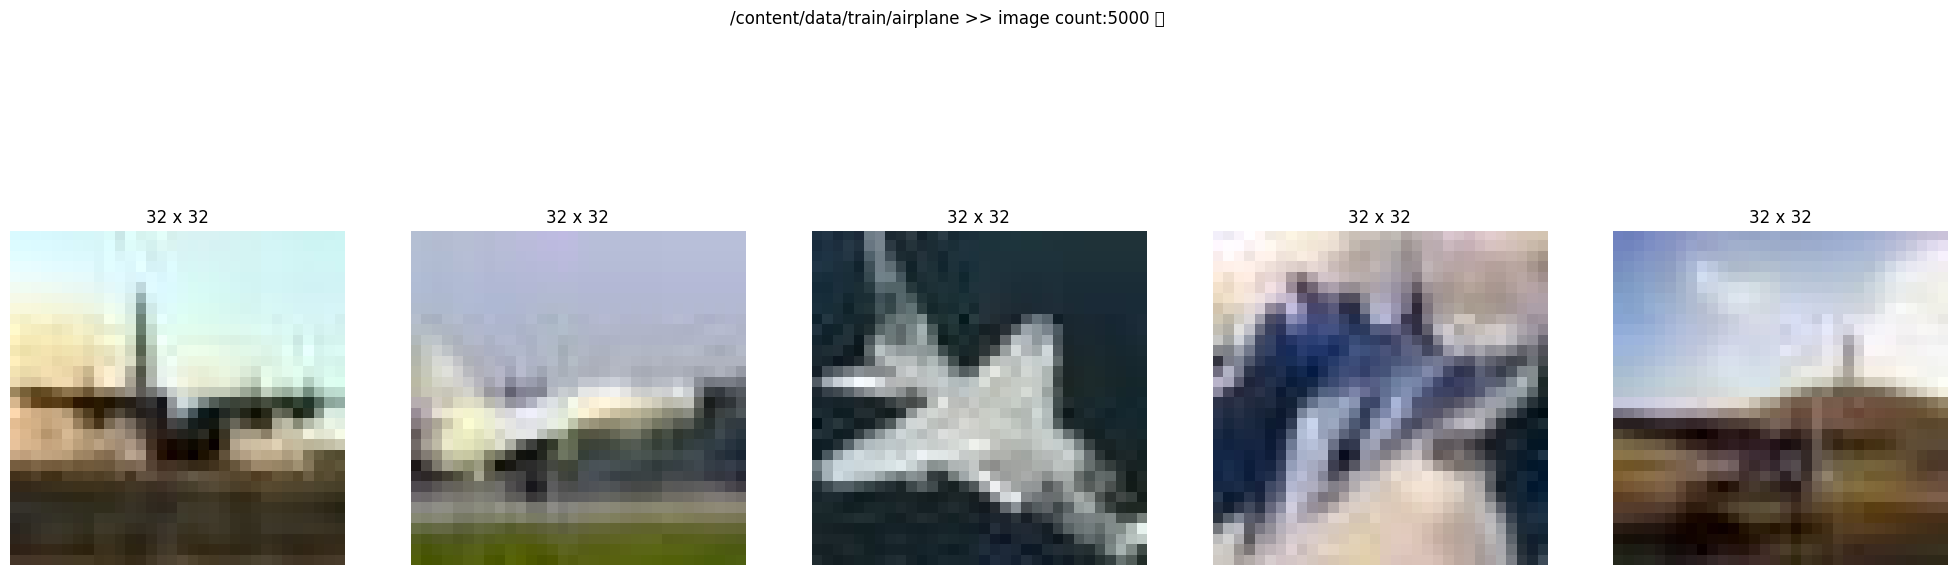

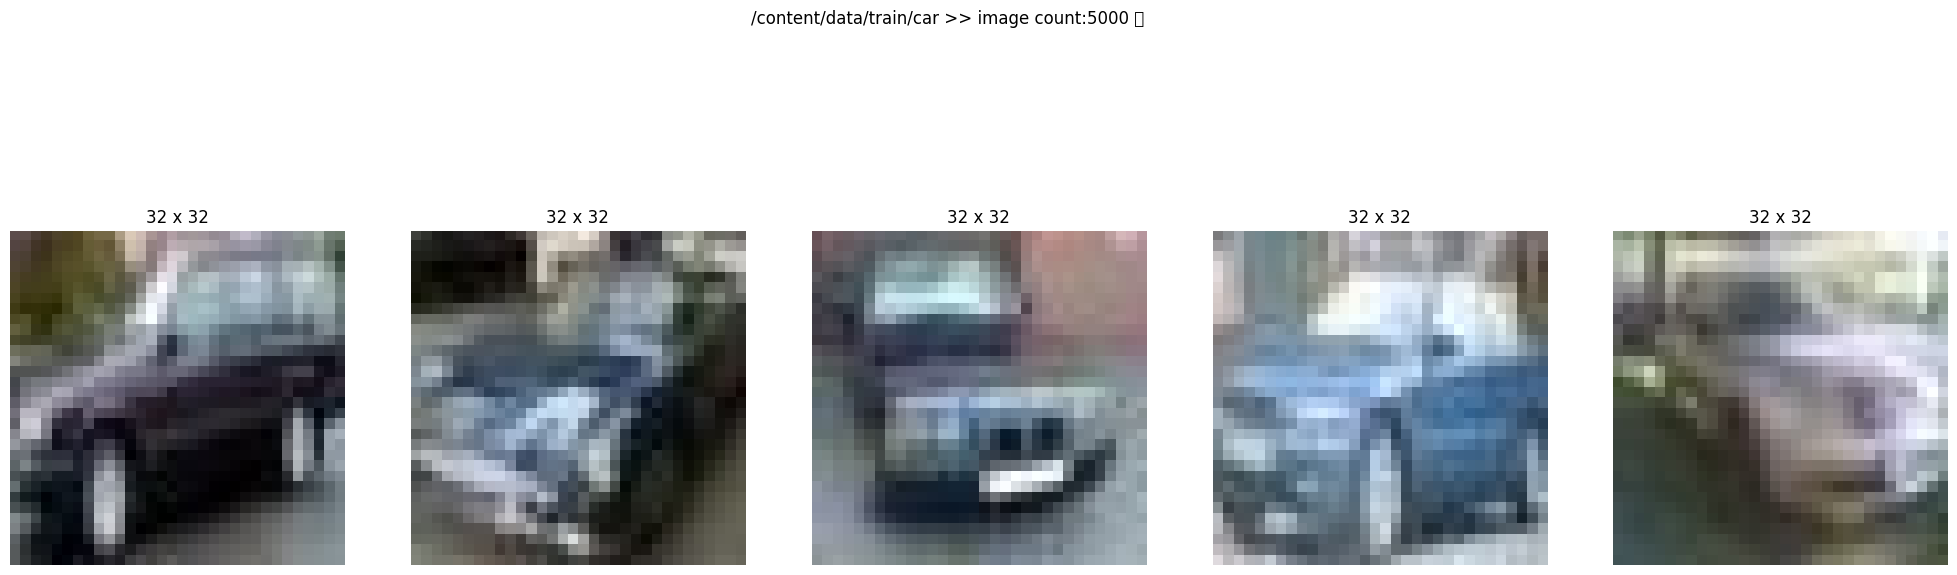

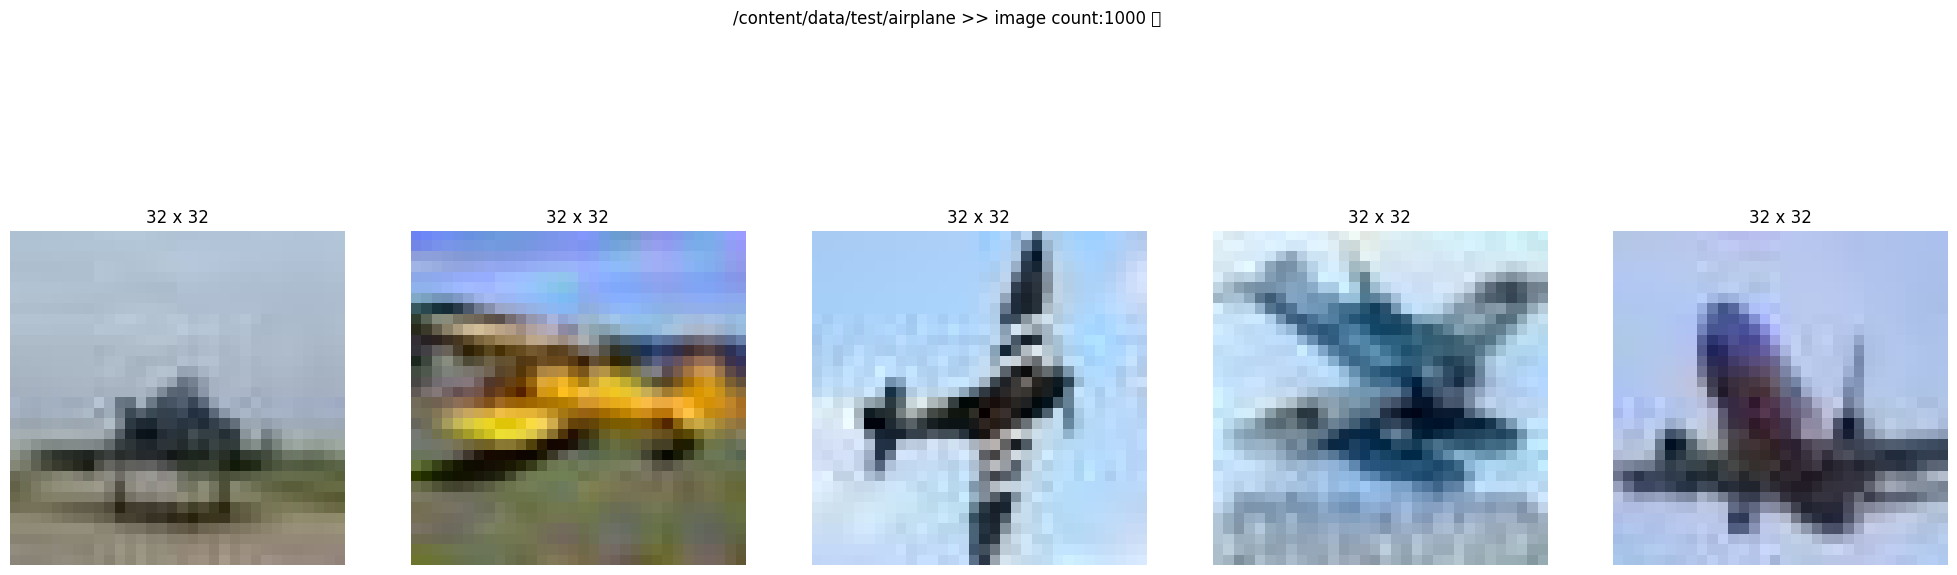

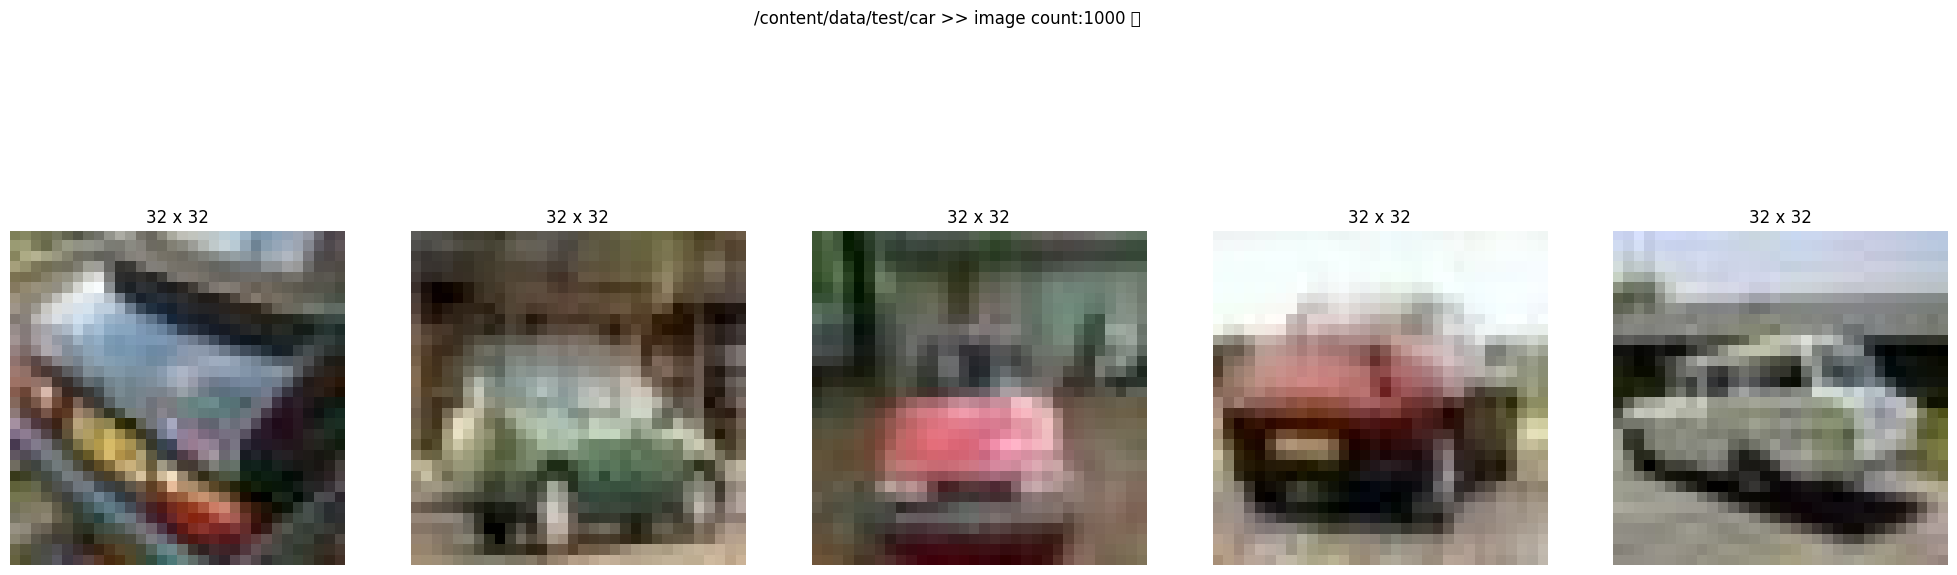

In [9]:
dirs = [train_dir, test_dir]
features = ['airplane', 'car']

for i, v in enumerate(dirs):
  for j, w in enumerate(features):
    target_dir = os.path.join(v, w)
    file_list = os.listdir(target_dir)
    file_count = len(file_list)

    fig, ax = plt.subplots(1, 5, figsize=(25,8), dpi=100)
    plt.suptitle("%s >> image count:%d 개" % (target_dir, file_count))

    for k, x in enumerate(ax):
      file_path = os.path.join(target_dir, file_list[k])
      sample = Image.open(file_path)
      x.set_title("%d x %d" % (sample.size[0], sample.size[1]))
      x.imshow(sample)
      x.axis('off')

    plt.show()
    plt.close()

## #03. 데이터 전처리 (이미지 데이터 증강)

In [11]:
train_datagen = ImageDataGenerator( rescale = 1.0/255 )
test_datagen = ImageDataGenerator( rescale = 1.0/255 )

train_set = train_datagen.flow_from_directory(train_dir, classes=['airplane', 'car'],
                                              batch_size=20, class_mode='binary', # 이미지를 증강시킬 배수, # 이진분류용임을 명시
                                              target_size=(32, 32)) # 변환될 이미지 해상도 기존의 것보다 늘리는 것은 안됨 해상도이슈

test_set = test_datagen.flow_from_directory(test_dir, classes=['airplane', 'car'], batch_size=20,
                                            class_mode='binary', target_size=(32, 32))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        8256      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        2

In [13]:
start = dt.datetime.now()

result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

end = dt.datetime.now()

delta = end - start

"총 학습 소요 시간: %d(초)" % delta.seconds

Epoch 1/500
500/500 [==============================] - 19s 15ms/step - loss: 0.3715 - acc: 0.8638 - val_loss: 0.3808 - val_acc: 0.8865 - lr: 0.0010
Epoch 2/500
500/500 [==============================] - 8s 15ms/step - loss: 0.2071 - acc: 0.9157 - val_loss: 0.1752 - val_acc: 0.9255 - lr: 0.0010
Epoch 3/500
500/500 [==============================] - 8s 16ms/step - loss: 0.1558 - acc: 0.9383 - val_loss: 0.1894 - val_acc: 0.9230 - lr: 0.0010
Epoch 4/500
500/500 [==============================] - 7s 13ms/step - loss: 0.1273 - acc: 0.9495 - val_loss: 0.1748 - val_acc: 0.9385 - lr: 0.0010
Epoch 5/500
500/500 [==============================] - 8s 16ms/step - loss: 0.0991 - acc: 0.9646 - val_loss: 0.1420 - val_acc: 0.9480 - lr: 0.0010
Epoch 6/500
500/500 [==============================] - 7s 13ms/step - loss: 0.0907 - acc: 0.9662 - val_loss: 0.2040 - val_acc: 0.9300 - lr: 0.0010
Epoch 7/500
500/500 [==============================] - 8s 16ms/step - loss: 0.0748 - acc: 0.9719 - val_loss: 0.2716 -

'총 학습 소요 시간: 87(초)'

## #05. 학습 결과 평가

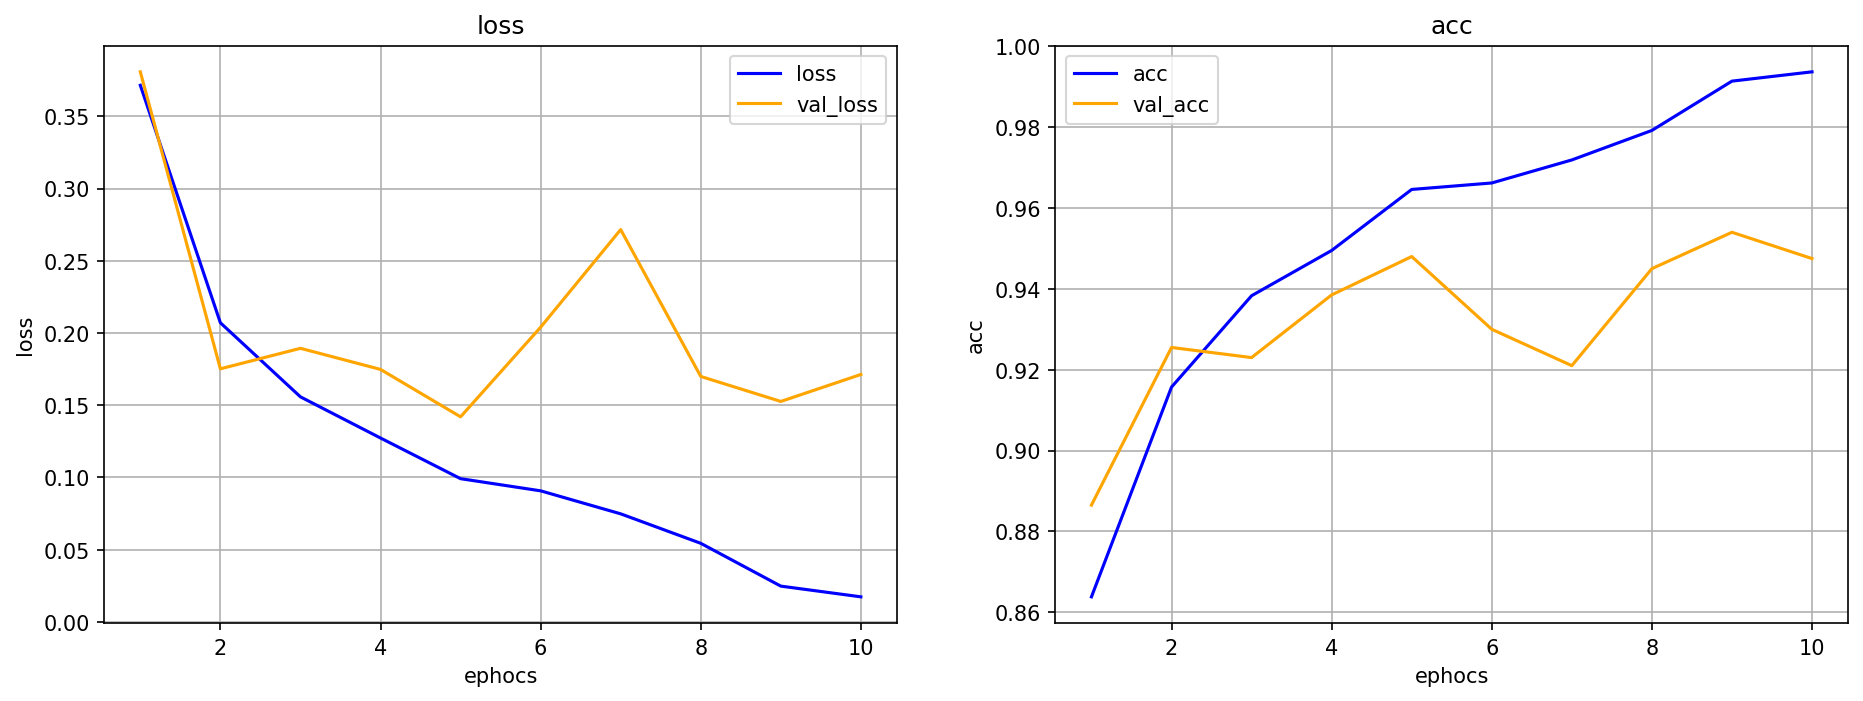

500/500 [==============================] - 5s 10ms/step - loss: 0.0068 - acc: 0.9982
최종 훈련 손실률: 0.006843, 최종 훈련 정확도: 0.998200
100/100 [==============================] - 1s 10ms/step - loss: 0.1713 - acc: 0.9475
최종 검증 손실률: 0.171267, 최종 검증 정확도: 0.947500


In [14]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(train_set)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(test_set)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #06. 학습 결과 적용

### 1. 훈련 데이터에 대한 예측 결과를 산정

In [15]:
pred = model.predict(train_set)
data_count, case_count = pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
pred

500/500 [==============================] - 5s 10ms/step
10000개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[9.9977714e-01],
       [9.3560475e-01],
       [1.0000000e+00],
       ...,
       [1.7781686e-12],
       [1.0000000e+00],
       [6.2563252e-08]], dtype=float32)

### 2. 예측 결과(확률)를 반올림하여 예측치 생성

In [16]:
pred_result = np.round(pred)
pred_result = pred_result.flatten()
pred_result

array([1., 1., 1., ..., 0., 1., 0.], dtype=float32)

### 3. 실제 이미지, 레이블, 예측치 확인

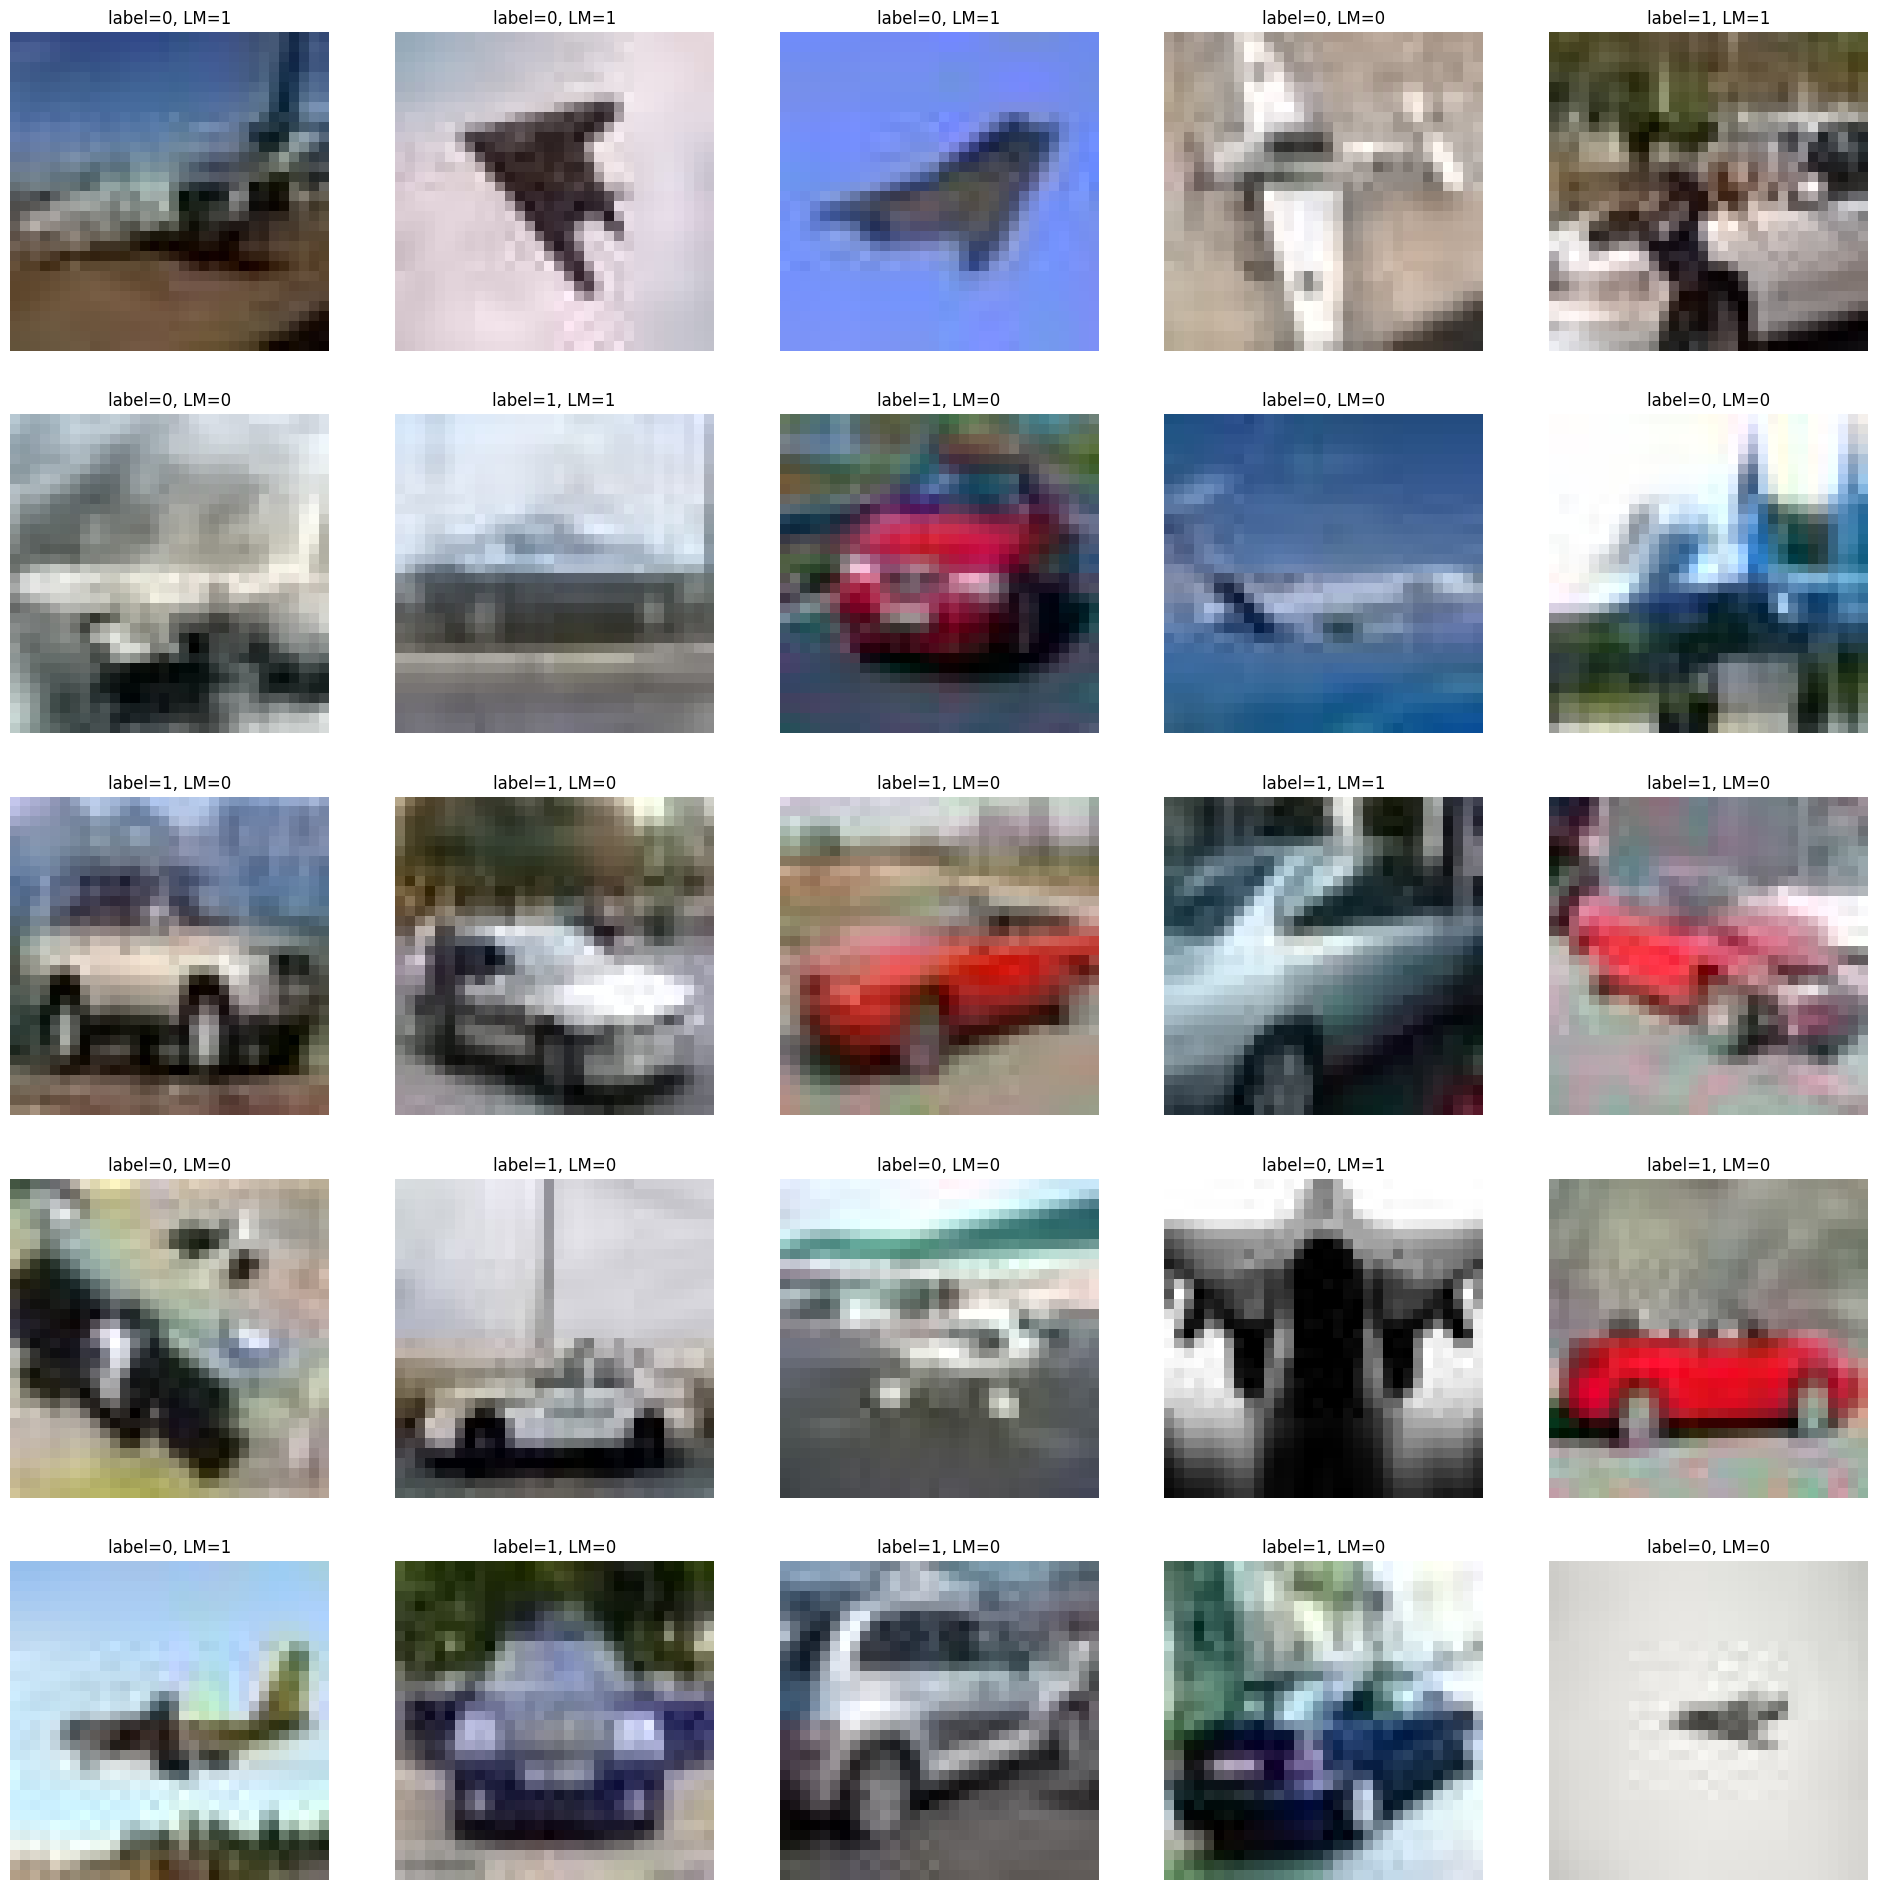

In [17]:
row = 5
col = 5
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

size = row*col
length = len(train_set)

for i in range(0, size):
    img, label = train_set.next()
    ax[i//col][i%col].imshow(img[0])
    ax[i//col][i%col].set_title("label=%d, LM=%d" % (label[0], pred_result[i]))
    ax[i//col][i%col].axis('off')

plt.show()
plt.close()